<a href="https://colab.research.google.com/github/siwon333/Mobile-Net---Classification/blob/main/%EB%AA%A8%EB%B0%94%EC%9D%BC%EB%84%B7%EB%B6%84%EB%A5%98_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# 필요한 라이브러리 임포트
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense
from keras.applications import MobileNet
from keras.optimizers import Adam

# 이미지 사이즈 및 경로 설정
img_rows, img_cols = 224, 224
train_data_dir = '/content/drive/MyDrive/dataset/train'
validation_data_dir = '/content/drive/MyDrive/dataset/test'
num_classes = 2  # '상한 귤', '정상 귤'

# MobileNet 모델 불러오기
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3))

# 상단 모델 추가
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# 레이어 동결 해제 (전이 학습을 위함)
for layer in base_model.layers:
    layer.trainable = True

# 데이터 증강 및 제너레이터 설정
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode='categorical'
)

# 모델 컴파일
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])

# 모델 학습
epochs = 5

history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // batch_size
)


Found 732 images belonging to 2 classes.
Found 134 images belonging to 2 classes.


<ipython-input-2-ad3849c81aed>:64: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/5
22/22 [==============================] - 178s 7s/step - loss: 0.2666 - accuracy: 0.9400 - val_loss: 8.7579 - val_accuracy: 0.8281
Epoch 2/5
22/22 [==============================] - 26s 1s/step - loss: 0.0227 - accuracy: 0.9929 - val_loss: 15.7745 - val_accuracy: 0.8203
Epoch 3/5
22/22 [==============================] - 25s 1s/step - loss: 0.0074 - accuracy: 0.9972 - val_loss: 11.9575 - val_accuracy: 0.8203
Epoch 4/5
22/22 [==============================] - 27s 1s/step - loss: 0.0035 - accuracy: 0.9986 - val_loss: 6.1594 - val_accuracy: 0.8438
Epoch 5/5
22/22 [==============================] - 25s 1s/step - loss: 6.4524e-04 - accuracy: 1.0000 - val_loss: 2.1383 - val_accuracy: 0.9219


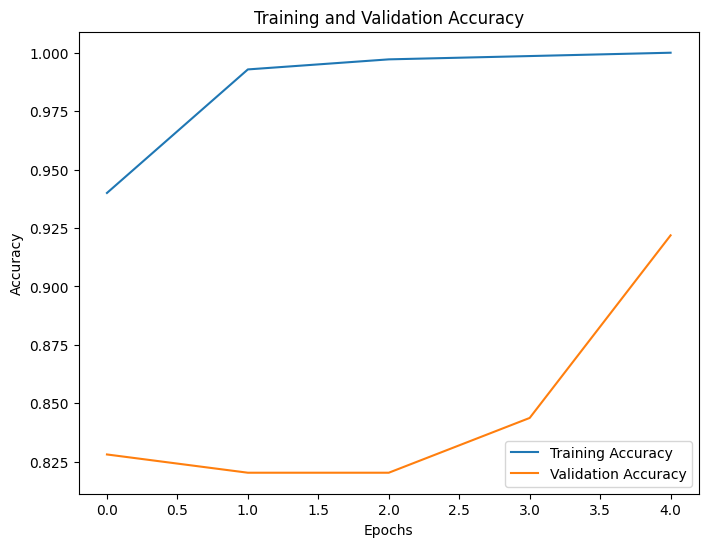

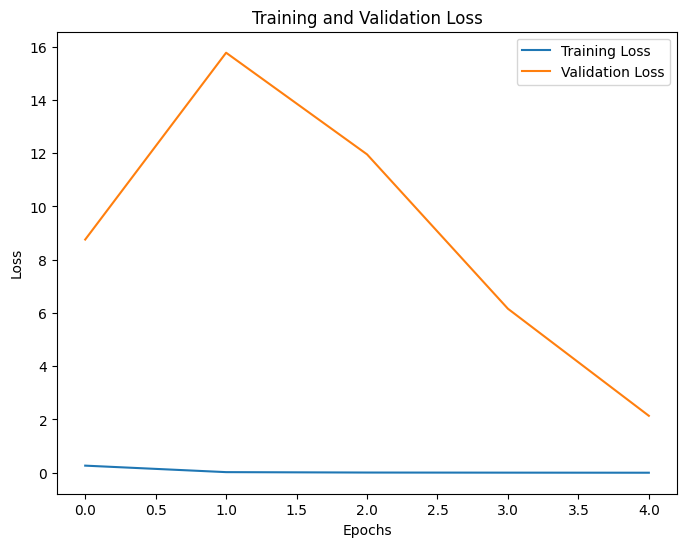

In [5]:
import matplotlib.pyplot as plt

# 정확도와 손실 가져오기
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# 정확도 그래프
plt.figure(figsize=(8, 6))
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 손실 그래프
plt.figure(figsize=(8, 6))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


1/1 [==============================] - 1s 714ms/step
이미지 '/content/30.jpg'의 예측 결과: 상한 귤
1/1 [==============================] - 0s 19ms/step
이미지 '/content/istockphoto-1313569860-612x612.jpg'의 예측 결과: 정상 귤


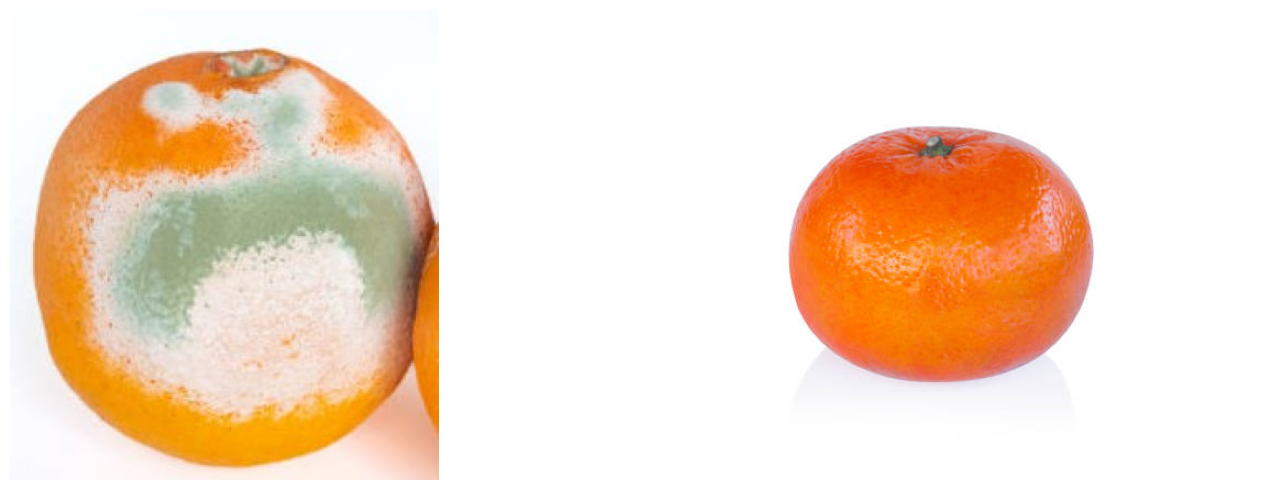

In [4]:
from keras.preprocessing import image
import numpy as np

def predict_images(image_paths, model):
    class_dict = {0: '정상 귤', 1: '상한 귤'}

    for img_path in image_paths:
        img = image.load_img(img_path, target_size=(img_rows, img_cols))
        img = image.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        img = img / 255.0  # 이미지 정규화

        prediction = model.predict(img)
        predicted_class = np.argmax(prediction)

        print(f"이미지 '{img_path}'의 예측 결과: {class_dict[predicted_class]}")

def show_images(image_paths):
    num_images = len(image_paths)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    for i, img_path in enumerate(image_paths):
        img = image.load_img(img_path)
        img = image.img_to_array(img)
        img = img / 255.0  # 이미지 정규화

        axes[i].imshow(img)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# 이미지 경로 리스트
image_list = [
    '/content/30.jpg',
    '/content/istockphoto-1313569860-612x612.jpg'
]

predict_images(image_list, model)
show_images(image_list)

Found 134 images belonging to 2 classes.
5/5 [==============================] - 3s 565ms/step


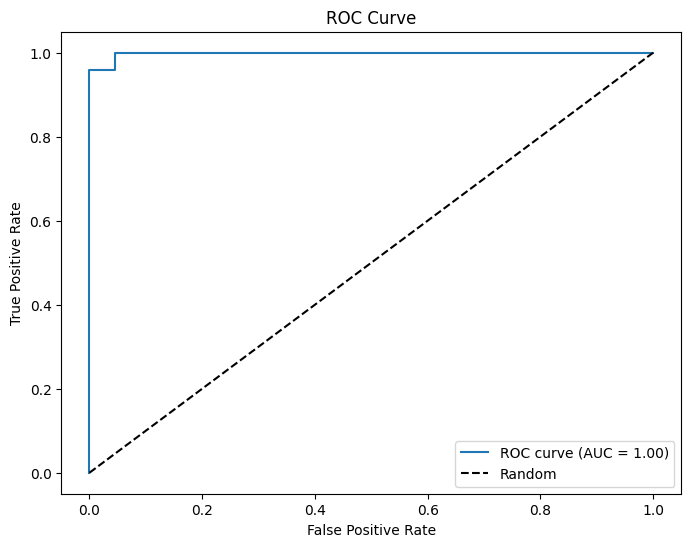

In [6]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# 테스트 데이터셋에 대한 예측값 계산
test_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

predictions = model.predict(test_generator)
y_true = test_generator.classes  # 실제 라벨

# ROC 커브 생성
fpr, tpr, thresholds = roc_curve(y_true, predictions[:, 1])  # 상한 귤 클래스에 대한 확률값을 사용합니다.
roc_auc = roc_auc_score(y_true, predictions[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


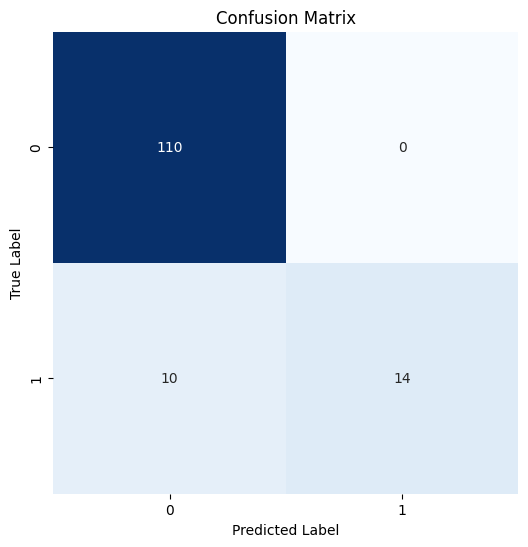

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 테스트 데이터셋에 대한 예측값이 이미 위에서 얻어졌다고 가정합니다.
# predictions: 모델의 예측값, y_true: 실제 라벨
# 이 값들이 존재하지 않는다면, 위에서 얻은 predictions, y_true를 여기서 사용하세요.

# 테스트 데이터셋 클래스 개수에 맞게 예측값 조정 (상한 귤, 정상 귤)
y_pred = np.argmax(predictions, axis=1)

# 혼동 행렬 생성
conf_matrix = confusion_matrix(y_true, y_pred)

# 혼동 행렬 시각화
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
